In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42877")
client

<Client: 'tcp://127.0.0.1:42877' processes=8 threads=32, memory=125.87 GiB>

In [2]:
import numpy as np
import xarray as xr
import xrft
import xwavelet
import os.path as op
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/groups/climode/tuchida/pyqg-runs/'

In [4]:
N = 512
# ds = xr.open_zarr(op.join(ddir,'Two-layer-QG/Cal1/rd=100km_outputs.zarr')
#                  )
ds = xr.open_zarr(op.join(ddir,'Two-layer-QG/N%04d/rd=100km_A1e-15_outputs.zarr' % N)
                 )
ds = xr.concat([ds, xr.open_zarr(op.join(ddir,'Two-layer-QG/N%04d/rd=100km_A1e-15_outputs02.zarr' % N))
               ], 'time')
# ds = ds.isel(time=list(range(0,len(ds.time),4)))
ds

<xarray.Dataset>
Dimensions:            (time: 720, l: 512, k: 257, lev: 2, y: 512, x: 512,
                        lev_mid: 1)
Coordinates:
  * k                  (k) float64 0.0 6.283e-06 1.257e-05 ... 0.001602 0.001608
  * l                  (l) float64 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * lev                (lev) int64 1 2
  * lev_mid            (lev_mid) float64 1.5
  * time               (time) float64 8.64e+05 8.64e+05 ... 8.64e+05 8.64e+05
  * x                  (x) float64 976.6 2.93e+03 ... 9.971e+05 9.99e+05
  * y                  (y) float64 976.6 2.93e+03 ... 9.971e+05 9.99e+05
Data variables: (12/33)
    APEflux            (time, l, k) float64 dask.array<chunksize=(1, 128, 257), meta=np.ndarray>
    APEgen             (time) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    APEgenspec         (time, l, k) float64 dask.array<chunksize=(1, 128, 257), meta=np.ndarray>
    Dissspec           (time, l, k) float64 dask.array<chunksize=(1, 128, 257), meta=np.ndarray>
    EKE                (time, lev) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    EKEdiss            (time) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    ...                 ...
    u                  (time, lev, y, x) float64 dask.array<chunksize=(1, 1, 128, 128), meta=np.ndarray>
    ufull              (time, lev, y, x) float64 dask.array<chunksize=(1, 1, 128, 128), meta=np.ndarray>
    uh                 (time, lev, l, k) complex128 dask.array<chunksize=(1, 1, 128, 257), meta=np.ndarray>
    v                  (time, lev, y, x) float64 dask.array<chunksize=(1, 1, 128, 128), meta=np.ndarray>
    vfull              (time, lev, y, x) float64 dask.array<chunksize=(1, 1, 128, 128), meta=np.ndarray>
    vh                 (time, lev, l, k) complex128 dask.array<chunksize=(1, 1, 128, 257), meta=np.ndarray>
Attributes: (12/23)
    pyqg:L:          1000000.0
    pyqg:M:          262144
    pyqg:W:          1000000.0
    pyqg:beta:       0.0
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tavestart:  0.0
    pyqg:tc:         1440
    pyqg:tmax:       864000.0
    pyqg:twrite:     432000
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

In [5]:
h = xr.DataArray(np.array([500.,2000.]), dims='lev', 
                 coords={'lev':ds.lev})
EKE = ((ds.EKE * h).sum('lev') / h.sum())

$$ APE = \frac{H^2}{2L_d^2}\left(\frac{\partial\psi}{\partial z}\right)^2 $$

In [6]:
rd = 100e3/(2*np.pi)
Ld = rd*2*np.pi
APE = (.5*Ld**-2*h.sum()**2
       * (ds.p.diff('lev')/1250.)**2
      ).isel(lev=0).compute().chunk({'time':10,'y':128,'x':128})
APE

<xarray.DataArray (time: 720, y: 512, x: 512)>
dask.array<xarray-<this-array>, shape=(720, 512, 512), dtype=float64, chunksize=(10, 128, 128), chunktype=numpy.ndarray>
Coordinates:
    lev      int64 2
  * time     (time) float64 8.64e+05 8.64e+05 8.64e+05 ... 8.64e+05 8.64e+05
  * x        (x) float64 976.6 2.93e+03 4.883e+03 ... 9.971e+05 9.99e+05
  * y        (y) float64 976.6 2.93e+03 4.883e+03 ... 9.971e+05 9.99e+05

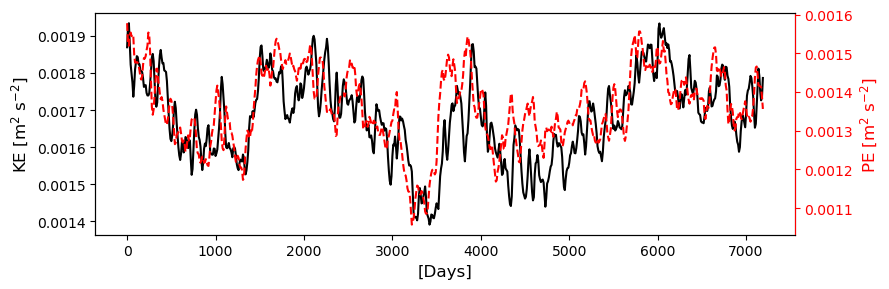

In [7]:
fig, ax = plt.subplots(figsize=(9,3))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(np.arange(0,7200,10), EKE.data, 'k')
ax2.plot(np.arange(0,7200,10), APE.mean(['y','x']).data, 'r--')

ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')

ax.set_ylabel(r"KE [m$^2$ s$^{-2}$]", fontsize=12)
ax2.set_ylabel(r"PE [m$^2$ s$^{-2}$]", fontsize=12, color='r')
ax.set_xlabel(r"[Days]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/Energy_timeseries.pdf'))